In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math, re
from google.colab import files

print("원본(202501_clean2.xlsx), 사전 적합도([8.28] Tx-적합도.xlsx) 업로드")
uploaded = files.upload()

원본(202501_clean2.xlsx), 사전 적합도([8.28] Tx-적합도.xlsx) 업로드


Saving [8.28] Tx-적합도.xlsx to [8.28] Tx-적합도 (5).xlsx
Saving 202501_clean2.xlsx to 202501_clean2 (5).xlsx


In [35]:
RAW_PATH = '202501_clean2.xlsx'
TX_PATH  = '[8.28] Tx-적합도.xlsx'

# 설정값
SELECTION_POLICY = 'composite'

# 복합 점수 가중치 (총합=1 권장)
WEIGHTS = {
    'ks_p': 0.5,   # 높을수록 우수
    'ad':   0.3,   # 낮을수록 우수
    'chi2': 0.2    # 낮을수록 우수
}

KS_P_THRESHOLD = 0.05
FALLBACK_DIST  = ('lognorm', '로그 정규')

In [36]:
# 원본 로딩 및 전처리

df = pd.read_excel(RAW_PATH)
if 'Pump-Begin' in df.columns:
    df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'], errors='coerce')

metal_columns = [c for c in df.columns if '(ng/m3)' in c]
df[metal_columns] = (df[metal_columns]
                     .apply(pd.to_numeric, errors='coerce')
                     .mask(df[metal_columns] < 0))

target_tags = ['Cr','Co','Ni','As','Cd','Sb','Pb']
target_cols = [c for c in metal_columns if any(c.startswith(t+'(') for t in target_tags)]
print(f"[INFO] 대상 금속 컬럼({len(target_cols)}):", target_cols)


[INFO] 대상 금속 컬럼(7): ['Cr(ng/m3)', 'Co(ng/m3)', 'Ni(ng/m3)', 'As(ng/m3)', 'Cd(ng/m3)', 'Sb(ng/m3)', 'Pb(ng/m3)']


In [37]:
DIST_MAP = {'정규':'norm', '로그 정규':'lognorm', '감마':'gamma', '와이블':'weibull_min',
            '로지스틱':'logistic', '삼각형':'triang', '최대 극값':'gumbel_r', '최소 극값':'gumbel_l',
            '지수':'expon', '균일':'uniform', '베타':'beta', '파레토':'pareto', '스튜던트의 t':'t',
            'BetaPERT':'beta'}

def _sheet_score(df_):
    txt = " ".join([str(x) for x in df_.columns] + df_.astype(str).head(200).stack().tolist())
    score = sum(w in txt for w in ['분포','K-S','P-값','카이제곱'])
    return score

def parse_tx_excel_strong(xlsx_path):
    xls = pd.ExcelFile(xlsx_path)
    best_blocks, best_count, best_sheet = None, 0, None
    for sname in xls.sheet_names:
        raw = pd.read_excel(xlsx_path, sheet_name=sname)
        if _sheet_score(raw) < 5:
            continue
        blocks = {}
        A = raw.fillna("").astype(str)
        # 금속 블록 시작행 탐지
        starts = []
        for i in range(len(A)-1):
            first_val = A.iloc[i, 0].strip()
            next_row_has_header = (A.iloc[i+1, :].eq('분포')).any()
            if first_val not in ("", "데이터 계열") and next_row_has_header:
                starts.append(i)
        # 블록 분할
        for idx, s in enumerate(starts):
            e = starts[idx+1] if idx+1 < len(starts) else len(A)
            metal_name = A.iloc[s, 0].strip()
            header_row = s+1
            table = raw.iloc[header_row:e].copy()
            table.columns = table.iloc[0].tolist()
            table = table.iloc[1:].reset_index(drop=True)
            keep = ['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수']
            table = table[[c for c in keep if c in table.columns]]
            table = table.dropna(subset=['분포'])
            blocks[metal_name] = table
        if len(blocks) > best_count:
            best_blocks, best_count, best_sheet = blocks, len(blocks), sname
    return best_blocks or {}, best_sheet

tx_blocks, used_sheet = parse_tx_excel_strong(TX_PATH)
print(f"[INFO] 사전 적합도 파싱된 금속 수: {len(tx_blocks)}  (시트: {used_sheet})")
print("[INFO] 파싱 키 일부:", list(tx_blocks.keys())[:10])

[INFO] 사전 적합도 파싱된 금속 수: 0  (시트: None)
[INFO] 파싱 키 일부: []


In [38]:
# 선택 로직
def _num(s):
    try:
        return pd.to_numeric(s, errors='coerce')
    except Exception:
        return pd.Series([np.nan]*len(s)) if hasattr(s, '__len__') else np.nan

def pick_best_dist_by_composite(table):
    t = table.copy()
    # 대상 컬럼 숫자화
    for col in ['K-S P-값', 'A-D', '카이제곱']:
        if col in t.columns:
            t[col] = _num(t[col])

    # 게이트 : KS P >= threshold 후보군 존재 시 그 안에서 선택
    subset = t[t.get('K-S P-값', pd.Series(dtype=float)) >= KS_P_THRESHOLD]
    cand = subset if len(subset) else t.copy()

    # 순위
    if 'K-S P-값' in cand.columns and cand['K-S P-값'].notna().any():
        r_ks = cand['K-S P-값'].rank(pct=True)
    else:
        r_ks = pd.Series(0.5, index=cand.index)

    if 'A-D' in cand.columns and cand['A-D'].notna().any():
        r_ad = 1.0 - cand['A-D'].rank(ascending=True, pct=True)
    else:
        r_ad = pd.Series(0.5, index=cand.index)

    if '카이제곱' in cand.columns and cand['카이제곱'].notna().any():
        r_chi2 = 1.0 - cand['카이제곱'].rank(ascending=True, pct=True)
    else:
        r_chi2 = pd.Series(0.5, index=cand.index)

    score = (WEIGHTS['ks_p'] * r_ks.fillna(0.5) +
             WEIGHTS['ad']   * r_ad.fillna(0.5) +
             WEIGHTS['chi2'] * r_chi2.fillna(0.5))

    cand = cand.assign(_score=score, _r_ks=r_ks, _r_ad=r_ad, _r_chi2=r_chi2).sort_values('_score', ascending=False)


    cand = cand.sort_values(by=['_score',
                                'K-S P-값' if 'K-S P-값' in cand.columns else '_score',
                                'A-D' if 'A-D' in cand.columns else '_score',
                                '카이제곱' if '카이제곱' in cand.columns else '_score'],
                            ascending=[False, False, True, True])

    chosen_row = cand.iloc[0]
    kor_name = str(chosen_row['분포'])
    return DIST_MAP.get(kor_name, None), kor_name, cand

def pick_best_dist_by_ks_only(table):
    t = table.copy()
    if 'K-S P-값' in t.columns:
        t['K-S P-값'] = _num(t['K-S P-값'])
        good = t[t['K-S P-값'] >= KS_P_THRESHOLD].sort_values('K-S P-값', ascending=False)
        base = good if len(good) else t.sort_values('K-S P-값', ascending=False)
        kor_name = str(base.iloc[0]['분포'])
        return DIST_MAP.get(kor_name, None), kor_name, base
    # KS P-값 자체가 없으면 첫 행
    kor_name = str(t.iloc[0]['분포'])
    return DIST_MAP.get(kor_name, None), kor_name, t

def pick_best_dist(table):
    if SELECTION_POLICY == 'composite':
        return pick_best_dist_by_composite(table)
    else:
        return pick_best_dist_by_ks_only(table)

# 백업 매핑
backup_map = {'Cr' : ('norm','정규'),
              'Co' : ('beta','베타'),
              'Ni' : ('weibull_min','와이블'),
              'Cd' : ('triang','삼각형'),
              'Sb' : ('triang','삼각형'),
              'Pb' : ('expon','지수')}

In [39]:
# 피팅 유틸 + 플로팅
def _fit_with_guard(dist, data, force_loc0=False):
    try:
        return dist.fit(data, floc=0) if force_loc0 else dist.fit(data)
    except Exception:
        return dist.fit(data)

def fit_distribution(data, dist_name):
    x = np.asarray(data, float)
    x = x[~np.isnan(x)]
    if x.size < 5:
        raise ValueError("표본 수 부족(n<5).")

    positive_only = {'lognorm','gamma','weibull_min','expon','pareto'}
    if dist_name in positive_only:
        x = x[x > 0]
        if x.size < 5:
            raise ValueError("양수 지지 분포: 유효 표본 부족.")

    dist = getattr(stats, dist_name)

    if dist_name == 'beta':
        xmin, xmax = np.nanmin(x), np.nanmax(x)
        if not np.isfinite(xmin) or not np.isfinite(xmax) or xmax-xmin == 0:
            raise ValueError("Beta fit 불가(범위 0).")
        z = (x - xmin) / (xmax - xmin)
        a,b,loc,scale = _fit_with_guard(dist, z, force_loc0=True)
        return (a,b, xmin, xmax-xmin), x  # (a,b,loc,scale) with original scale

    if dist_name == 'triang':
        try:
            c, loc, scale = dist.fit(x)
            return (c, loc, scale), x
        except Exception:
            hist, edges = np.histogram(x, bins='fd')
            xmin, xmax = np.nanmin(x), np.nanmax(x)
            mode = (edges[np.argmax(hist)] + edges[np.argmax(hist)+1]) / 2
            c = (mode - xmin) / (xmax - xmin + 1e-12)
            c = float(np.clip(c, 1e-6, 1-1e-6))
            return (c, xmin, xmax-xmin), x

    force0 = dist_name in {'lognorm','gamma','weibull_min','expon','pareto'}
    params = _fit_with_guard(dist, x, force_loc0=force0)
    return params, x

def ks_pvalue(x, dist_name, params):
    return float(stats.kstest(x, dist_name, args=params)[1])

def format_params(dist_name, params):
    try:
        if dist_name == 'lognorm':
            s, loc, scale = params; return f"s={s:.3g}, loc={loc:.3g}, scale={scale:.3g}"
        if dist_name in {'gamma','weibull_min','t','beta','pareto'}:
            names = ['a','b','loc','scale'][:len(params)]
            return ", ".join(f"{n}={v:.3g}" for n,v in zip(names, params))
        if dist_name in {'gumbel_r','gumbel_l','expon','logistic','norm','uniform'}:
            names = ['loc','scale','arg3','arg4'][:len(params)]
            return ", ".join(f"{n}={v:.3g}" for n,v in zip(names, params))
        if dist_name == 'triang':
            c, loc, scale = params; return f"c={c:.3g}, loc={loc:.3g}, scale={scale:.3g}"
        return str(params)
    except:
        return str(params)

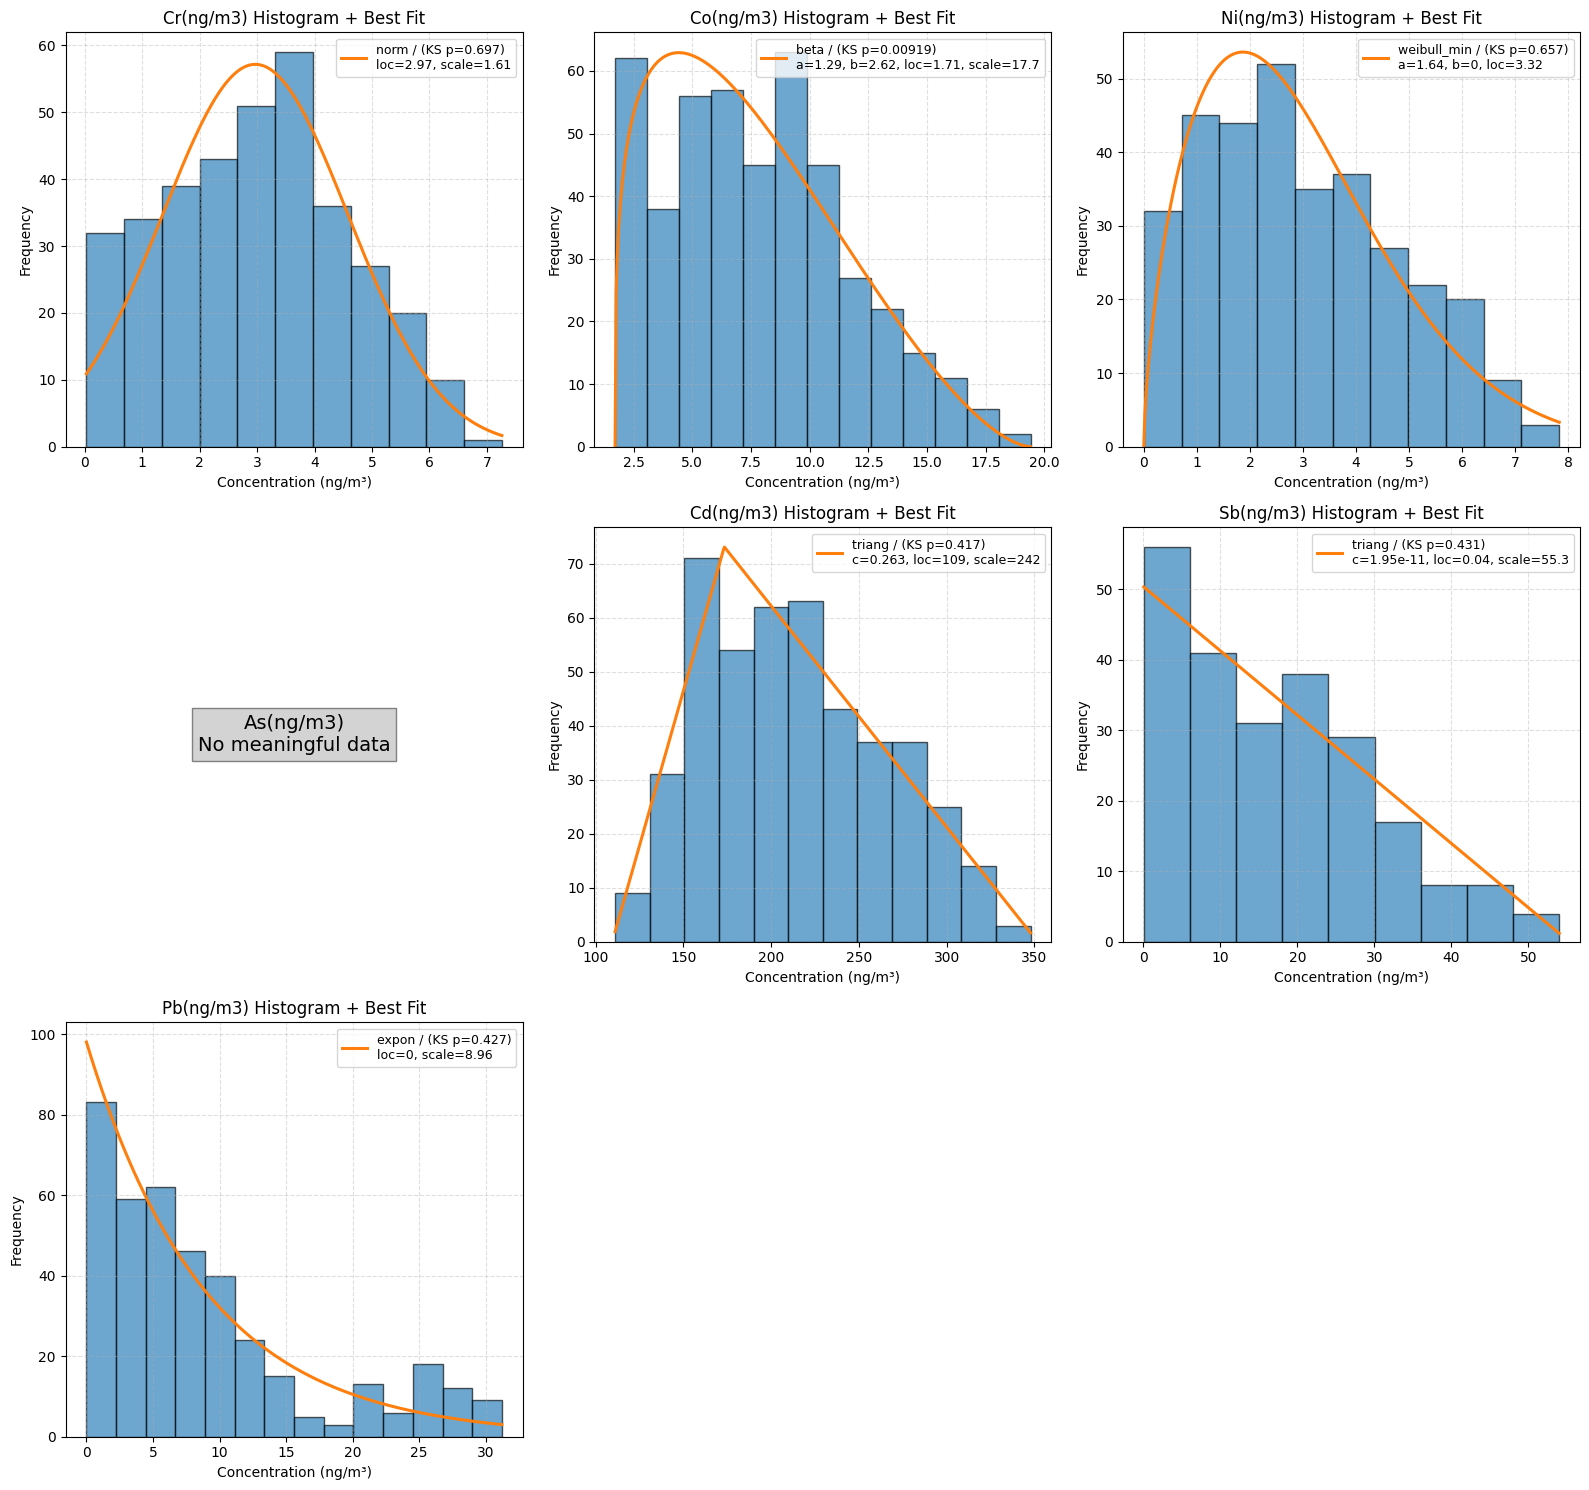

In [46]:
# 히스토그램 + 단일 분포 피팅
summary_rows = []
diagnostic_rows = []

n = len(target_cols)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 5*nrows))
axes = np.ravel(axes) if n > 1 else [axes]

for i, col in enumerate(target_cols):
    ax = axes[i]
    s = pd.to_numeric(df[col], errors='coerce').dropna()

    if s.nunique() <= 1 or len(s) < 5:
        ax.axis('off')
        ax.text(0.5, 0.5, f"{col}\nNo meaningful data",
                ha='center', va='center', fontsize=14, transform=ax.transAxes,
                bbox=dict(facecolor='lightgray', edgecolor='gray'))
        continue

    # 히스토그램
    counts, bins, _ = ax.hist(s, bins='auto', density=False, edgecolor='black', alpha=0.65)
    ax.set_title(f"{col} Histogram + Best Fit")
    ax.set_xlabel("Concentration (ng/m³)")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.4)

    # 최적 분포 선택
    best = None
    tag = col.split('(')[0].strip()
    key = next((k for k in tx_blocks.keys() if k.strip().lower()==tag.lower()), None)

    chosen_table = None
    if key is not None:
        try:
            scipy_name, kor_name, chosen_table = pick_best_dist(tx_blocks[key])
            if scipy_name:
                best = (scipy_name, kor_name)
        except Exception:
            best = None

    # 파싱/선택 실패 시 백업
    if not best:
        if tag in backup_map:
            best = backup_map[tag]
        else:
            best = FALLBACK_DIST

    best_scipy, best_kor = best

    # 피팅 + 오버레이
    try:
        params, used = fit_distribution(s.values, best_scipy)
        p = ks_pvalue(used, best_scipy, params)

        N = len(used)
        bin_w = float(np.mean(np.diff(bins)))
        xgrid = np.linspace(bins[0], bins[-1], 400)
        dist = getattr(stats, best_scipy)
        pdf = dist.pdf(xgrid, *params) * N * bin_w  # 빈도 스케일

        label = f"{best_scipy} / (KS p={p:.3g})\n{format_params(best_scipy, params)}"
        ax.plot(xgrid, pdf, lw=2.2, label=label)

        summary_rows.append({'Metal': col,
                             'ChosenDist(KOR)': best_kor,
                             'ChosenDist(SciPy)': best_scipy,
                             'KS_p (fit)': p,
                             'Params': format_params(best_scipy, params),
                             'N_used': N,
                             'bin_width_mean': bin_w,
                             'Policy': SELECTION_POLICY,
                             'TX_Sheet': used_sheet})

        # 선택 근거 저장
        if isinstance(chosen_table, pd.DataFrame) and '_score' in chosen_table.columns:
            ct = chosen_table.copy()
            ct['Metal'] = col
            diagnostic_rows.append(ct[['Metal','분포','K-S P-값','A-D','카이제곱','_r_ks','_r_ad','_r_chi2','_score']].reset_index(drop=True))

    except Exception as e:
        ax.text(0.5, 0.15, f"fit_error: {e}", ha='center', transform=ax.transAxes,
                bbox=dict(facecolor='mistyrose', edgecolor='red'))
        summary_rows.append({'Metal': col,
                             'ChosenDist(KOR)': best_kor,
                             'ChosenDist(SciPy)': best_scipy,
                             'KS_p (fit)': np.nan,
                             'Params': f'fit_error: {e}',
                             'N_used': len(s),
                             'bin_width_mean': np.nan,
                             'Policy': SELECTION_POLICY,
                             'TX_Sheet': used_sheet})

    ax.legend(fontsize=9, loc='best', frameon=True)

# 남는 축 숨김
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()